Homework 1
Andrew Plassard
Bios 8366


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import math


## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:


(-48, 1234)

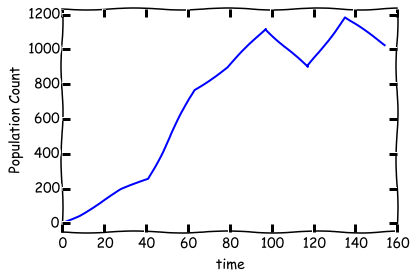

In [2]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.xkcd()

fig, ax = plt.subplots()
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')

#plt.xticks([])
#plt.yticks([])

ax.plot(days, beetles, label='Observed')
ax.set_xlabel('time')
ax.set_ylabel('Population Count')
ax.set_ylim([min(beetles)-50, max(beetles)+50])


1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.
2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

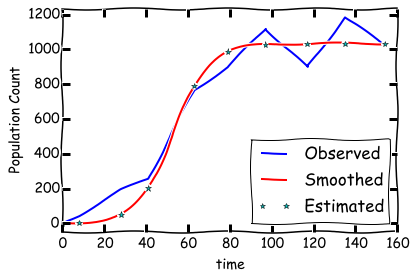

In [3]:
'''Solution to part 1'''
from scipy.optimize import curve_fit

def sigmoid(x, k, r):
    N0 = 2
    s = (k*N0)/(N0+(k-N0)*np.exp(-r*x))
    return s

xdata = np.array(days)
ydata = np.array(beetles)
# Run curve fitting with some reasonable initializations based on the data
popt,pcov = curve_fit(sigmoid, xdata, ydata, [1200,.1])
y_hat = sigmoid(xdata, popt[0], popt[1])
x_est = np.arange(xdata.max()+1)
y_hat_smooth = sigmoid(x_est, popt[0], popt[1])

plt.xkcd()

fig, ax = plt.subplots()
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')

#plt.xticks([])
#plt.yticks([])

ax.plot(days, beetles, label='Observed')
ax.plot(x_est, y_hat_smooth, label='Smoothed')
ax.plot(days, y_hat, '*', label='Estimated')
ax.set_xlabel('time')
ax.set_ylabel('Population Count')
ax.set_ylim([min(beetles)-50, max(beetles)+50])
ax.legend(loc=0)

In [4]:
'''Solution to part 2'''

'Solution to part 2'

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



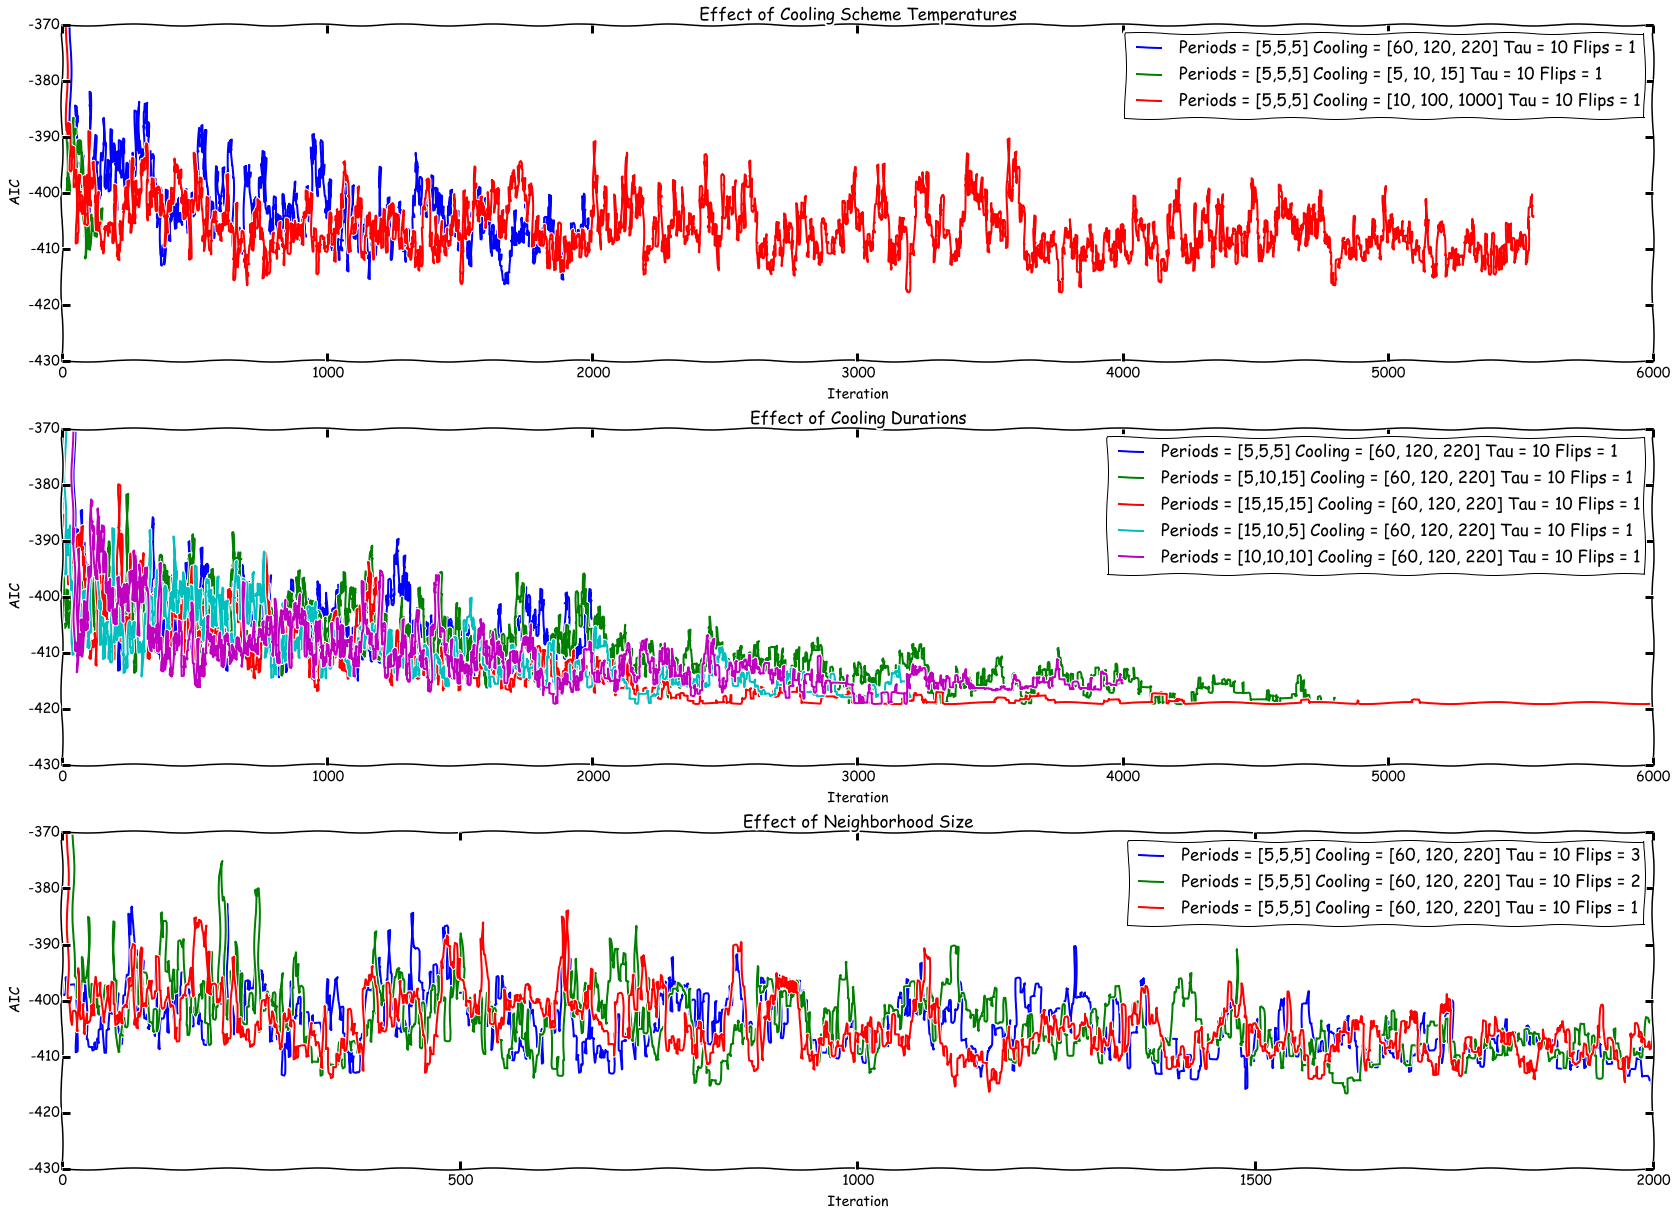

In [5]:
'''Solution to part 1'''

import pandas as pd
import scipy
import numpy as np

aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)


def run_simulated_annealing(X, y, num_periods, cooling_lengths, tau_start, num_flips):
    cooling = []
    periods = 0
    aic_values = []

    # Set up cooling and periods
    for i in range(len(num_periods)):
        cooling_length = [cooling_lengths[i]] * num_periods[i]
        cooling.extend(cooling_length)
        periods += num_periods[i]

    tau = [tau_start * 0.9**i for i in range(periods)]

    # Set up initial solution
    ncols = X.shape[1]
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = X[X.columns[solution_current]]
    g = pd.ols(y=y, x=solution_vars)
    aic_best = aic(g)
    aic_values.append(aic_best)

    #print len(aic_values),aic_values[-1]

    for j in range(periods):
        for i in range(cooling[j]):
            # slight change
            flips = []
            for _ in range(num_flips):
                flip = np.random.randint(0, ncols)
                flips.append(flip)
            for flip in flips:
                solution_current[flip] = not solution_current[flip]
            solution_vars = X[X.columns[solution_current]]
            g = pd.ols(y=y, x=solution_vars)
            aic_step = aic(g)
            alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau[j]))

            if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                aic_values.append(aic_step)
                if aic_step < aic_best:
                    # Replace previous best with this one
                    aic_best = aic_step
                    if aic_step < aic_best:
                        # Replace previous best with this one
                        aic_best = aic_step
                        solution_best = solution_current.copy()
            else:
                aic_values.append(aic_values[-1])
                for flip in flips:
                    solution_current[flip] = not solution_current[flip]
    return aic_values

baseball = pd.read_table('../data/textbook/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)

tests1 = {}
tests1['Periods = [5,5,5] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [60, 120, 220], 10, 1)
tests1['Periods = [5,5,5] Cooling = [10, 100, 1000] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [10, 100, 1000], 10, 1)
tests1['Periods = [5,5,5] Cooling = [5, 10, 15] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [5, 10, 15], 10, 1)

plt.xkcd()

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

colors = ['b','g','r','c','m','y','k']

plt.subplot(3,1,1)

n = 0
keys = sorted(tests1.keys())
keys.reverse()
for key in keys:
    plt.plot(tests1[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care
    
plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.legend(loc=1)

plt.ylim([-430, -370])
plt.title('Effect of Cooling Scheme Temperatures')

tests2 = {}
tests2['Periods = [5,5,5] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [60, 120, 220], 10, 1)
tests2['Periods = [10,10,10] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [10, 10, 10], [60, 120, 220], 10, 1)
tests2['Periods = [15,15,15] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [15, 15, 15], [60, 120, 220], 10, 1)
tests2['Periods = [5,10,15] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 10, 15], [60, 120, 220], 10, 1)
tests2['Periods = [15,10,5] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [15, 10, 5], [60, 120, 220], 10, 1)

plt.subplot(3,1,2)

n = 0
keys = sorted(tests2.keys())
keys.reverse()
for key in keys:
    plt.plot(tests2[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care
    
plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.legend(loc=1)

plt.ylim([-430, -370])
plt.title('Effect of Cooling Durations')

tests3 = {}

tests3['Periods = [5,5,5] Cooling = [60, 120, 220] Tau = 10 Flips = 1'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [60, 120, 220], 10, 1)
tests3['Periods = [5,5,5] Cooling = [60, 120, 220] Tau = 10 Flips = 2'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [60, 120, 220], 10, 2)
tests3['Periods = [5,5,5] Cooling = [60, 120, 220] Tau = 10 Flips = 3'] = run_simulated_annealing(predictors, logsalary, [5, 5, 5], [60, 120, 220], 10, 3)

plt.subplot(3,1,3)

n = 0
keys = sorted(tests3.keys())
keys.reverse()
for key in keys:
    plt.plot(tests3[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care
    
plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.legend(loc=1)

plt.ylim([-430, -370])
plt.title('Effect of Neighborhood Size')

# Discussion
It appears that the effect of changing the cooling scheme temperatures causes simmulated annealing to achieve a better global solution. As the cooling temperatues increase, essentially more iterations are available to let it get to a stable point thus allowing it to find a "more comfortable" end condition.

The interesting observation from holding temperature fixed but modulating period length is when the periods all were much longer. The solution essentially converged and could never move over the hill to get past an AIC of around 415 (or below -415 in the graph).

When modulating the number of flips we see the distribution get to its lowest point when the number of flips at each iteration was the highest. In the beginning, when 3 flips were allowed the distribution fluctuated a lot more than with 2 or 1 flips. In the end though, all the flip schemes converged to a similar best AIC.

The overall takeaway from all of these is as the annealing scheme became more complex the solutions became better, but in general it is hard to tell if the result is truly an improvement or just an overfitting. A different metric like cross-validation or held-out sets may help address this. 

(-450, -350)

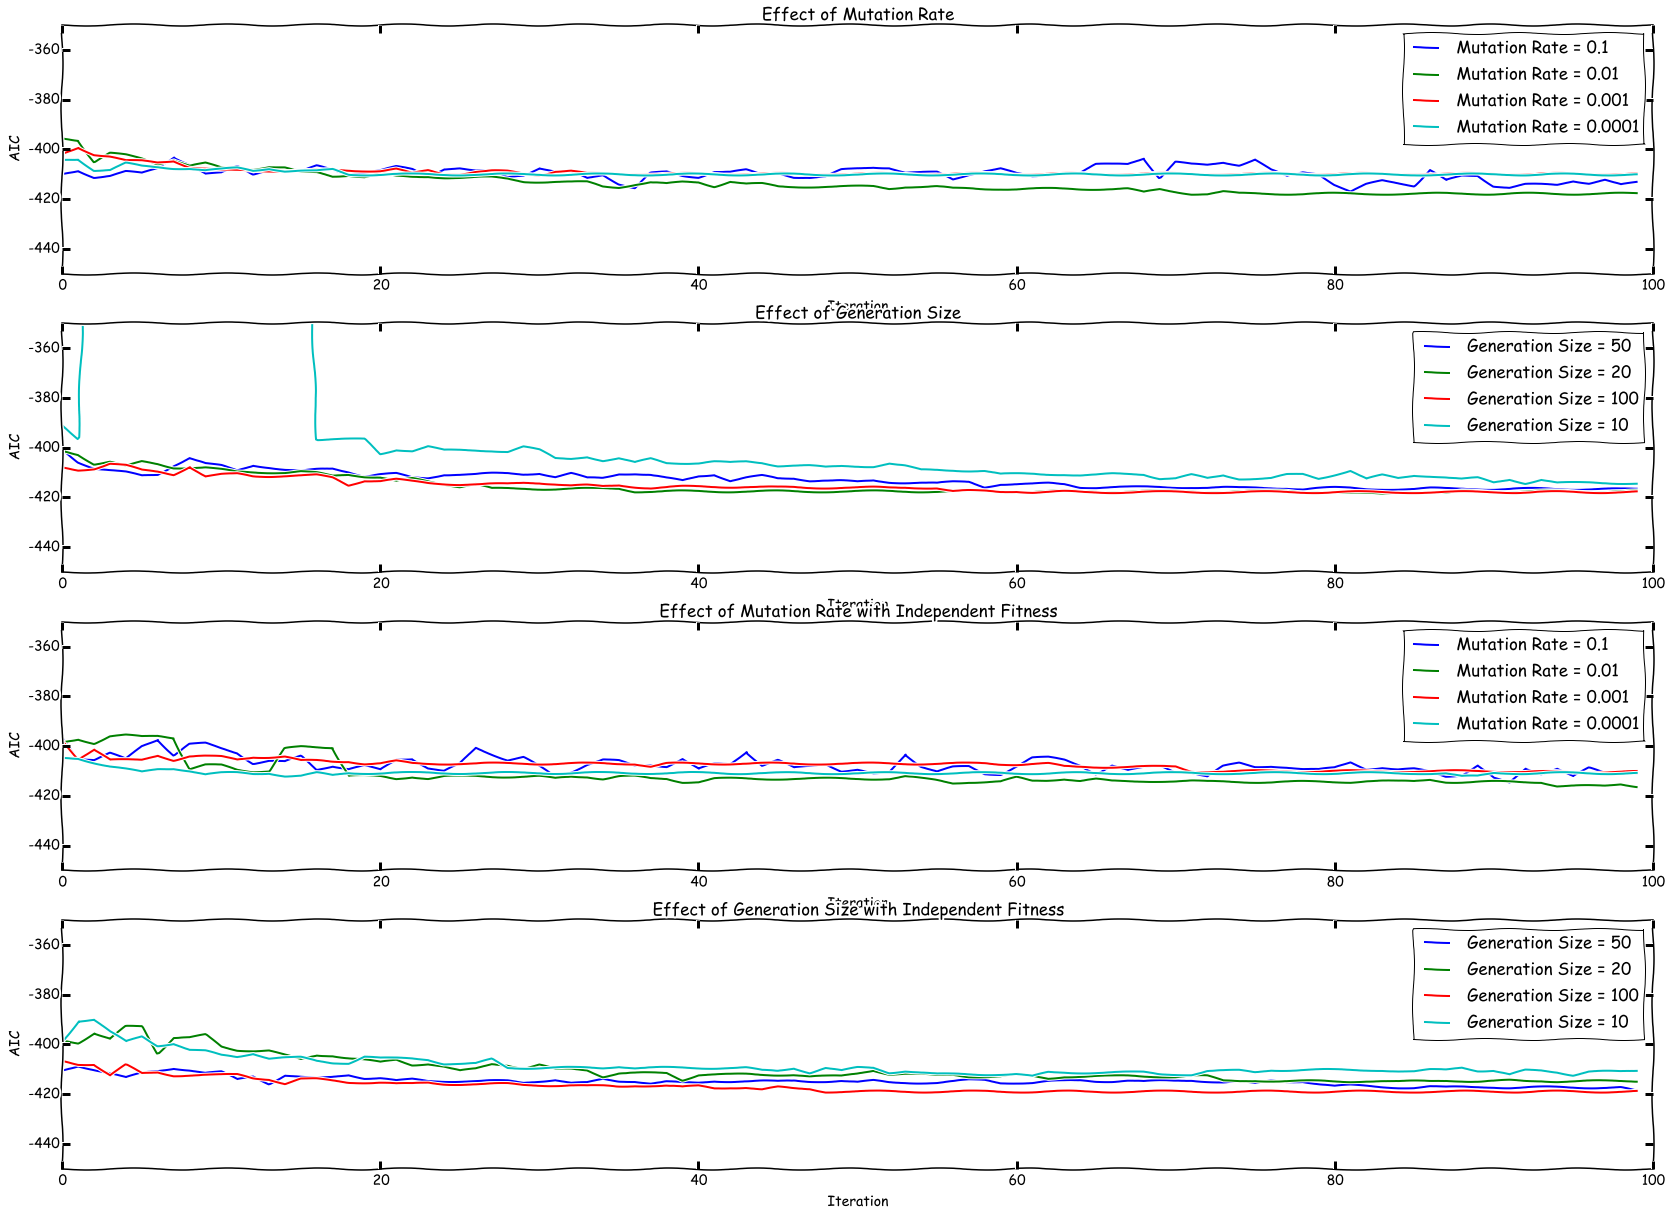

In [6]:
'''Solution to Part 2'''
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def run_genetic_algorithm(X, y, pop_size, iterations, mutation_rate):
    ncols = X.shape[1]
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    aic_best = []
    best_solution = []
    aic_history = []
    for i in range(iterations):
        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])
        
        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)
        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))
        
        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]
            
        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return aic_best

def run_genetic_algorithm_independent_fitness(X, y, pop_size, iterations, mutation_rate):
    ncols = X.shape[1]
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    aic_best = []
    best_solution = []
    aic_history = []
    for i in range(iterations):
        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])
        
        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)
        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly
        dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        
        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]
            
        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return aic_best

plt.xkcd()

fig, ax = plt.subplots()
fig.set_size_inches(28.5, 20.5)

colors = ['b','g','r','c','m','y','k']

tests1 = {}

tests1['Mutation Rate = 0.0001'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.0001)
tests1['Mutation Rate = 0.001'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.001)
tests1['Mutation Rate = 0.01'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.01)
tests1['Mutation Rate = 0.1'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.1)

plt.subplot(4,1,1)

n = 0
keys = sorted(tests1.keys())
keys.reverse()
for key in keys:
    plt.plot(tests1[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care

plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.title('Effect of Mutation Rate')
plt.legend(loc=1)
plt.ylim([-430,-380])

tests2 = {}

tests2['Generation Size = 10'] = run_genetic_algorithm(predictors, logsalary, 10, 100, 0.01)
tests2['Generation Size = 20'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.01)
tests2['Generation Size = 50'] = run_genetic_algorithm(predictors, logsalary, 50, 100, 0.01)
tests2['Generation Size = 100'] = run_genetic_algorithm(predictors, logsalary, 100, 100, 0.01)

plt.subplot(4,1,2)

n = 0
keys = sorted(tests2.keys())
keys.reverse()
for key in keys:
    plt.plot(tests2[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care

plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.legend(loc=1)
plt.ylim([-430,-380])
plt.title('Effect of Generation Size')

tests3 = {}

tests3['Mutation Rate = 0.0001'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.0001)
tests3['Mutation Rate = 0.001'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.001)
tests3['Mutation Rate = 0.01'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.01)
tests3['Mutation Rate = 0.1'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.1)

plt.subplot(4,1,3)

n = 0
keys = sorted(tests3.keys())
keys.reverse()
for key in keys:
    plt.plot(tests3[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care

plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.title('Effect of Mutation Rate with Independent Fitness')
plt.legend(loc=1)
plt.ylim([-430,-380])

tests4 = {}

tests4['Generation Size = 10'] = run_genetic_algorithm(predictors, logsalary, 10, 100, 0.01)
tests4['Generation Size = 20'] = run_genetic_algorithm(predictors, logsalary, 20, 100, 0.01)
tests4['Generation Size = 50'] = run_genetic_algorithm(predictors, logsalary, 50, 100, 0.01)
tests4['Generation Size = 100'] = run_genetic_algorithm(predictors, logsalary, 100, 100, 0.01)

plt.subplot(4,1,4)

n = 0
keys = sorted(tests4.keys())
keys.reverse()
for key in keys:
    plt.plot(tests4[key], colors[n], label=key)
    n += 1 # I know enumerate does this but I don't care

plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.legend(loc=1)
plt.title('Effect of Generation Size with Independent Fitness')
plt.ylim([-430,-380])

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there. I will award 5 bonus points to the best solution!

Best Cost: 126.017354
Best solution 0,4,10,12,15,20,25,24,23,22,21,19,18,17,16,13,14,11,9,8,7,5,6,3,2,1,0


(100, 550)

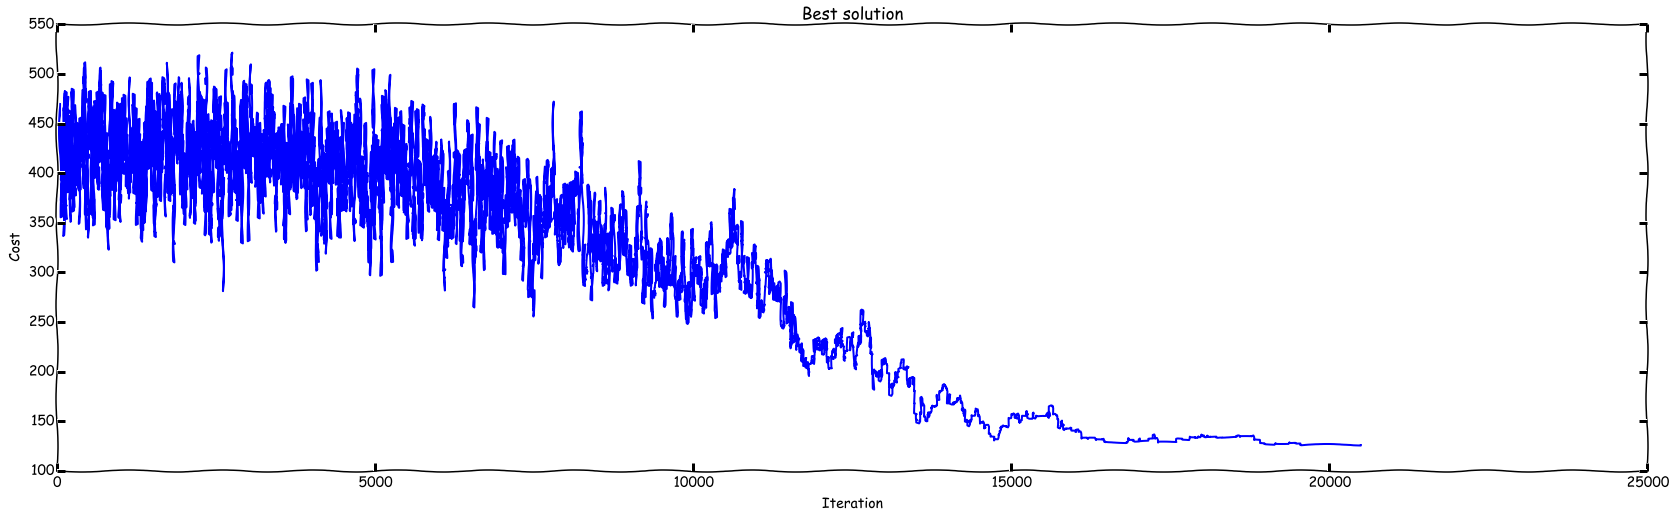

In [5]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

def cost(city_order, locations):
    total_distance = 0
    for i in range(1,len(city_order)):
        c1 = city_order[i-1]
        loc1 = locations[c1,:]
        c2 = city_order[i]
        loc2 = locations[c2,:]
        d = np.sqrt(np.power((loc1[1] - loc2[1]),2) + np.power(loc1[0] - loc2[0],2))
        total_distance += d
    return total_distance

def run_simulated_annealing(locations, num_periods, cooling_lengths, tau_start, num_flips):
    cooling = []
    periods = 0
    cost_values = []

    # Set up cooling and periods
    for i in range(len(num_periods)):
        cooling_length = [cooling_lengths[i]] * num_periods[i]
        cooling.extend(cooling_length)
        periods += num_periods[i]

    tau = [tau_start * 0.9**i for i in range(periods)]

    # Set up initial solution
    n_cities = locations.shape[0]
    a = np.random.permutation(np.arange(n_cities-1)+1).tolist()
    a.append(0)
    a.reverse()
    a.append(0)
    city_order = a
    
    best_cost = cost(city_order, locations)
    cost_values.append(best_cost)
    best_solution = city_order
    
    for j in range(periods):
        for i in range(cooling[j]):
            # slight change
            flips = []
            for _ in range(num_flips):
                flip = np.random.choice(n_cities - 1,2)
                flip = flip + 1 # eliminate first and last from consideration
                flips.append(flip)
            for flip in flips:
                f1 = flip[0]
                f2 = flip[1]
                n1 = city_order[f1]
                n2 = city_order[f2]
                city_order[f1] = n2
                city_order[f2] = n1
            current_cost = cost(city_order, locations)
            alpha = min(1, np.exp((cost_values[-1] - current_cost)/tau[j]))
            if (current_cost < cost_values[-1]) or (np.random.uniform() < alpha):
                cost_values.append(current_cost)
                if current_cost < best_cost:
                    best_cost = current_cost
                    best_solution = city_order
            else:
                cost_values.append(cost_values[-1])
                flips.reverse()
                for flip in flips:
                    f1 = flip[0]
                    f2 = flip[1]
                    n1 = city_order[f1]
                    n2 = city_order[f2]
                    city_order[f1] = n2
                    city_order[f2] = n1
    
    return cost_values,best_solution
            

cities = np.array(cities)
plt.xkcd()

fig, ax = plt.subplots()
num_runs = 100
fig.set_size_inches(28.5, 8)

best_cost = 500
best_solution = []


for iter in range(num_runs):
    costs,solution = run_simulated_annealing(cities, [5, 10, 20,30], [100, 200, 300,400], 500, 1)
    m = min(costs)
    if m < best_cost:
        best_cost = m
        best_solution = solution
        best_costs = costs

print('Best Cost: %f' % best_cost)
print("Best solution %s" % ",".join(map(str,best_solution)))
plt.plot(best_costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Best solution')
plt.ylim([100, 550])

To solve this I used simulated annealing. In order to frame the problem around simulated anealing, I chose to make the order in which the cities were visited the variable of interest.  I manually tested . I then ran simulated annealing with 100 different starting configurations and my manually defined annealing scheme which seemed to produce good results. The best results I achieved was just above 126 and the solution is listed above.

## Question 4

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$g(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is posi- tive).
2. Using the prior density as a proposal density, design a rejection algo- rithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

Solution to 1:
In this case we hope to compute 
$$p\left(h > 0.5 | y = 5, n = 5\right)$$
where $h$ is the probability of getting head which we expand as
$$\int_{.5+}^{1} p\left( h | y=5, n=5 \right) dh $$

We can expand this with Bayes rule as

$$ \frac{\int_{.5+}^1 p\left( y=5 | h,n=5\right) p(h) dh}{\int_{0}^1 p\left( y=5 | h',n=5\right) p(h) dh'}$$

Since we know that $p\left(y | h,n\right)$ is binomial we can thus substitute this into the previous equation as

$$\frac{\int_{.5+}^1 h^y(1-h)^{n-y} p(h) dh}{\int_{0}^1 h'^y(1-h')^{n-y} p(h) dh'}$$

We can also convert our prior $N\left(0,.25\right)$ to be in terms of h as 

$$ \frac{1}{\sigma \sqrt{2\pi}} \exp{-\frac{\left(\log{\frac{h}{1-h}}-\mu\right)^2}{2\sigma^2}} = \frac{1}{.25 \sqrt{2\pi}} \exp{-\frac{\left(\log{\frac{h}{1-h}}-0\right)^2}{.125}} $$

And thus we can subsitute this into our equation for $p(h)$ as

$$\frac{\int_{.5+}^1 h^y(1-h)^{n-y} \frac{1}{.25 \sqrt{2\pi}} \exp{-\frac{\log{\frac{h}{1-h}}^2}{.125}} dh}{\int_{0}^1 h'^y(1-h')^{n-y} \frac{1}{.25 \sqrt{2\pi}} \exp{-\frac{\log{\frac{h'}{1-h'}}^2}{.125}} dh'}$$

We can futher simplify this since we know that $y = n$ to

$$\frac{\int_{.5+}^1 h^y \frac{1}{.25 \sqrt{2\pi}} \exp{-\frac{\log{\frac{h}{1-h}}^2}{.125}} dh}{\int_{0}^1 h'^y \frac{1}{.25 \sqrt{2\pi}} \exp{-\frac{\log{\frac{h'}{1-h'}}^2}{.125}} dh'}$$

and

$$\frac{\int_{.5+}^1 h^y \exp{-\frac{\log{\frac{h}{1-h}}^2}{.125}} dh}{\int_{0}^1 h'^y  \exp{-\frac{\log{\frac{h'}{1-h'}}^2}{.125}} dh'}$$

by factoring out constants

Probabiliy h>.5 from posterior: 0.724
Probabiliy h>.5 from a posteriori: 0.984
Probabiliy h>.5 from prior: 0.500


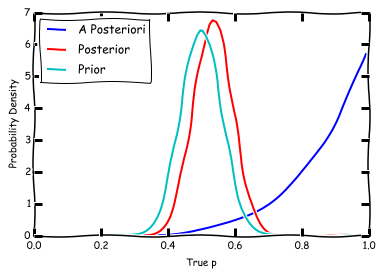

In [59]:
'''Solution using scipy to integrate'''

import scipy.integrate as integrate
import sys

prob = lambda h: (h**5) *math.exp(-(math.log(h/(1-h))**2)/.125)
prob2 = lambda h: (h**5) 
prior = lambda h: math.exp(-(math.log(h/(1-h))**2)/.125)
top1 = integrate.quad(prob, .5,1)
top2 = integrate.quad(prob2, .5,1)
top3 = integrate.quad(prior, .5,1)
bottom1 = integrate.quad(prob, 0,1)
bottom2 = integrate.quad(prob2, 0,1)
bottom3 = integrate.quad(prior, 0,1)
vals = np.linspace(0.01,.99,100)
probs = np.array([prob(x) for x in vals.tolist()]) / bottom[0]
probs2 = np.array([prob2(x) for x in vals.tolist()]) / bottom2[0]
probs3 = np.array([prior(x) for x in vals.tolist()]) / bottom3[0]
plt.plot(vals,probs2,label='A Posteriori')
plt.plot(vals,probs,label='Posterior')
plt.plot(vals,probs3,label='Prior')
plt.xlabel('True p')
plt.ylabel('Probability Density')
plt.legend(loc=0)
print('Probabiliy h>.5 from posterior: %0.3f' % (top1[0]/bottom1[0]))
print('Probabiliy h>.5 from a posteriori: %0.3f' % (top2[0]/bottom2[0]))
print('Probabiliy h>.5 from prior: %0.3f' % (top3[0]/bottom3[0]))